# Compute Phase Velocities
This code is used to compute the phase velocities of the fluctuations as a function of psi

## Loading and Setup

In [5]:
# %% Imports
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

from c1lgkt.fields.equilibrium import Equilibrium
from c1lgkt.fields.geometry_handlers import XgcGeomHandler

from tqdm.notebook import tqdm

from netCDF4 import Dataset

In [4]:
# %% Load data files
eq = Equilibrium.from_eqdfile(R'D:\Documents\IFS\hmode_jet\D3D141451.eqd')
xgcdata = Dataset(R'D:\Documents\Globus\XGC1.nc')

geom_files = {
    'ele_filename': R'D:\Documents\IFS\hmode_jet\Seo.eqd.ele',
    'fdmat_filename': R'D:\Documents\IFS\hmode_jet\fdmat.pkl',
    'min_e_filename': R'D:\Documents\IFS\hmode_jet\min_E_mat.pkl'
}
geom = XgcGeomHandler(eq, xgcdata, theta0_mode='max_drive', **geom_files)

## Compute Phase Velocities

In [6]:
# %% Compute the phase velocities using finite difference

t = xgcdata['t'][:]
u_lstsq = np.empty((len(t)-1, geom.nsurf))
phimax = np.empty((len(t)-1, geom.nsurf))

dpot1 = xgcdata['dpot'][0,:,:]

for tind in tqdm(range(len(t)-1)):
    dpot0 = dpot1
    dpot1 = xgcdata['dpot'][tind+1,:,:]
    
    dt = t[tind+1] - t[tind]
    for k in range(geom.nsurf):
        br = (geom.breaks_surf[k], geom.breaks_surf[k+1])

        npot0 = dpot0[:,br[0]:br[1]]
        npot1 = dpot1[:,br[0]:br[1]]
        
        # Compute dphi/dt
        phidt = (npot1 - npot0) / dt

        theta = geom.theta_node[br[0]:br[1]]
        dtheta = (np.mod((np.roll(theta, 1) - np.roll(theta, -1)) + np.pi, 2*np.pi) - np.pi)

        # Compute finite difference
        phida = (np.roll(npot0, 1, axis=-1) - np.roll(npot0, -1, axis=-1)) / dtheta[np.newaxis,:]

        u_lstsq[tind,k] = -np.sum(phidt * phida) / np.sum(phida**2)
        phimax[tind,k] = np.max(np.abs(npot1))

  0%|          | 0/499 [00:00<?, ?it/s]

### Save Data

In [7]:
np.savez('./outputs/phase_vel.npz', u_lstsq=u_lstsq, phimax=phimax)

### Analysis

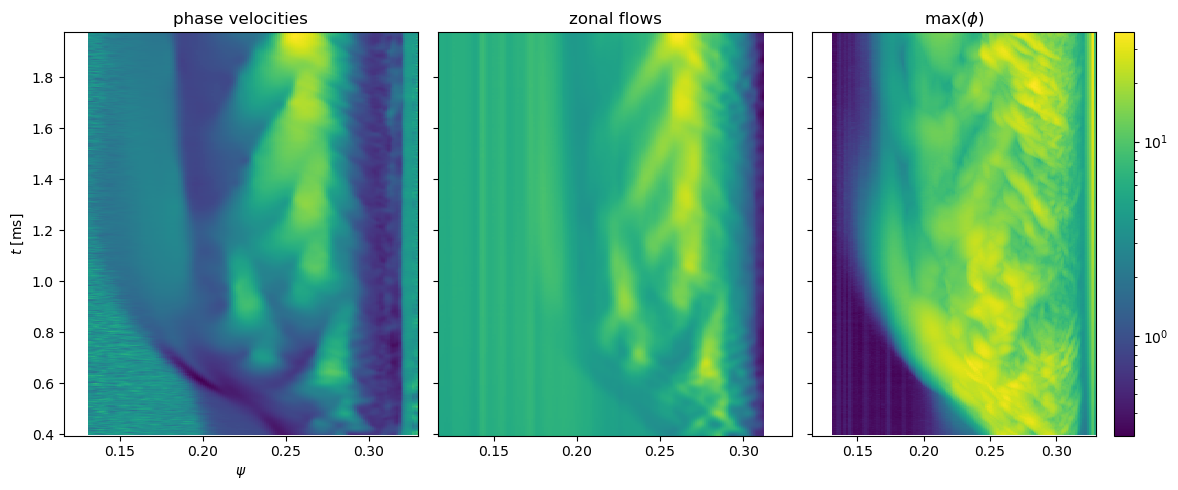

In [ ]:
# %% Colormaps of the computed phase velocities and zonal flows

## Compute zonal flows
zpot = xgcdata['pot00'][:,:]
zpot_psi = xgcdata['psi00'][:]

zfield = np.diff(zpot, axis=1) / np.diff(zpot_psi)[np.newaxis,:]

## Plot computed velocities
fig, axs = plt.subplots(1, 3, sharex='all', sharey='all', figsize=(12,5))


tind0 = 100
surf0 = 100

axs[0].pcolormesh(geom.psi_surf[surf0-1:], t[tind0:]*1e3, -u_lstsq[tind0:,surf0:])
axs[0].set_title('phase velocities')

axs[0].set_xlabel(R'$\psi$')
axs[0].set_ylabel(R'$t$ [ms]')

axs[1].pcolormesh(zpot_psi[100:-30], t[tind0-1:]*1e3, -zfield[tind0:,100:-30])
axs[1].set_title('zonal flows')

cbar = axs[2].pcolormesh(geom.psi_surf[surf0-1:], t[tind0:]*1e3, phimax[tind0:,surf0:], norm=mpl.colors.LogNorm())
plt.colorbar(cbar, ax=axs[2])
axs[2].set_title(R'max($\phi$)')

plt.tight_layout()

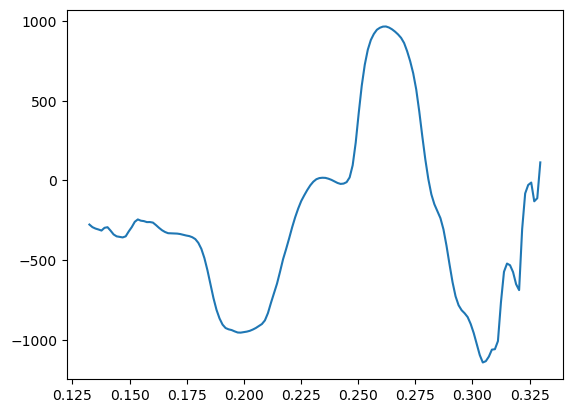

In [ ]:
# %% Plot of the phase velocity for a particular time
tind = 424
plt.figure()
plt.plot(geom.psi_surf[surf0:], -u_lstsq[tind,surf0:])

plt.xlabel(R'$\psi$')
plt.ylabel(R'$u$')